# Comparison of Different galaxy properties
Ipython notebook to compare galaxy properties derived using different methods.

In [1]:
import numpy as np
import h5py
from pydl.pydlutils.spheregroup import spherematch
from ChangTools.fitstables import mrdfits

import matplotlib.pyplot as plt
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
%matplotlib inline 

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Read in heterogeneous data
VAGC Group Catalog both centrals and satellites from Jeremy

In [2]:
# VAGC group catalog (all) M_r cut = 18
vagc_file = ''.join(['/Volumes/750GB/hahn/cenque/observations/', 'GroupCat.Mr18.Mass9.4.D360.all.hdf5']) 
f = h5py.File(vagc_file, 'r')
grp = f['data']

# save to dictionary
vagc = {}
for key in grp.keys(): 
    vagc[key] = grp[key].value

UV SFR from NSA (from Nitya)

In [3]:
nsa_file = ''.join(['/Volumes/750GB/hahn/cenque/observations/', 'nsaid_ra_dec_z_mass_uvssfr'])
nsa_dat = np.loadtxt(nsa_file, unpack=True, usecols=[1,2,3,4,5]) # ra, dec, z, mass (k-correct?), UV_ssfr

# save to dictionary
nsa = {} 
nsa['ra'] = nsa_dat[0]
nsa['dec'] = nsa_dat[1]
nsa['z'] = nsa_dat[2]
nsa['mass'] = np.log10(nsa_dat[3])
nsa['ssfr'] = nsa_dat[4]
nsa['sfr'] = nsa['mass'] + nsa['ssfr']

Salim et al. (2016) GSWLC catalog --- Catalog is generated from UV, Optical photometry

In [16]:
salim_file = ''.join(['/Volumes/750GB/hahn/cenque/observations/', 'GSWLC-D1.dat'])
salim_dat = np.loadtxt(salim_file, unpack=True, usecols=[5,6,7,9,11]) # ra, dec, z, mass, sfr

# save to dictionary
salim = {} 
salim['ra'] = salim_dat[0]
salim['dec'] = salim_dat[1]
salim['z'] = salim_dat[2]
salim['mass'] = salim_dat[3]
salim['sfr'] = salim_dat[4]
salim['ssfr'] = salim['sfr'] - salim['mass'] 

VAGC-GALEX with iSEDfit (John's catalog)

In [5]:
jm_kcorr_file = ''.join(['/Volumes/750GB/hahn/cenque/observations/', 'mf_parent_sdss.fits.gz'])
jm_kcorr_dat = mrdfits(jm_kcorr_file)

isedfit_file = ''.join(['/Volumes/750GB/hahn/cenque/observations/', 'ised_parent_supergrid01_sdss.fits.gz'])
isedfit_dat = mrdfits(isedfit_file)

if (np.abs(jm_kcorr_dat.zprimus - isedfit_dat.zobj)).max() != 0.: 
    raise ValueError

# save to dictionary
isedfit = {}
isedfit['ra'] = jm_kcorr_dat.ra
isedfit['dec'] = jm_kcorr_dat.dec
isedfit['z'] = isedfit_dat.zobj
isedfit['mass'] = isedfit_dat.mass_50
isedfit['sfr'] = isedfit_dat.sfr_50
isedfit['ssfr'] = isedfit['sfr'] - isedfit['mass']
isedfit['nuv'] = jm_kcorr_dat.k_fnuvugrizjhk_absmag_01[:,1]
isedfit['r'] = jm_kcorr_dat.k_fnuvugrizjhk_absmag_01[:,4]
isedfit['j'] = jm_kcorr_dat.k_fnuvugrizjhk_absmag_01[:,7]
isedfit['nuv-r'] = isedfit['nuv'] - isedfit['r']
isedfit['r-j'] = isedfit['r'] - isedfit['j']

In [6]:
primus_file = ''.join(['/Volumes/750GB/hahn/cenque/observations/', 'mfdata_all_supergrid01.fits.gz'])
primus_dat = mrdfits(primus_file)

# save to dictionary
primus = {}
primus['ra'] = primus_dat.ra
primus['dec'] = primus_dat.dec
primus['z'] = primus_dat.z
primus['mass'] = primus_dat.mass
primus['sfr'] = primus_dat.sfr
primus['ssfr'] = primus['sfr'] - primus['mass']

## match up all the galaxy properties
anchored to the vagc values

In [7]:
# prepare for all the matches
for cat in ['nsa', 'salim', 'isedfit']:
    for key in ['id', 'ra', 'dec', 'z', 'mass', 'sfr', 'ssfr']: 
        vagc_key = ''.join([cat, '_', key])
        if key == 'id': 
            vagc[vagc_key] = np.repeat(-999, len(vagc['ra']))
        else: 
            vagc[vagc_key] = np.repeat(-999., len(vagc['ra']))

In [8]:
m_vagc_nsa, m_nsa_vagc, dd = spherematch(vagc['ra'], vagc['dec'], nsa['ra'], nsa['dec'], 0.001)

if len(m_vagc_nsa) != len(np.unique(m_vagc_nsa)): 
    raise ValueError

for key in ['id', 'ra', 'dec', 'z', 'mass', 'sfr', 'ssfr']: 
    if key == 'id': 
        vagc['nsa_id'][m_vagc_nsa] = m_nsa_vagc
    elif key == 'mass':
        vagc['nsa_mass'][m_vagc_nsa] = vagc['mass'][m_vagc_nsa]
    else: 
        vagc['nsa_'+key][m_vagc_nsa] = nsa[key][m_nsa_vagc]
vagc['nsa_ssfr'][m_vagc_nsa] = vagc['nsa_sfr'][m_vagc_nsa] - vagc['nsa_mass'][m_vagc_nsa]

In [17]:
m_vagc_salim, m_salim_vagc, dd = spherematch(vagc['ra'], vagc['dec'], salim['ra'], salim['dec'], 0.001)

if len(m_vagc_salim) != len(np.unique(m_vagc_salim)): # make sure there's no repeats
    raise ValueError

for key in ['id', 'ra', 'dec', 'z', 'mass', 'sfr', 'ssfr']: 
    if key == 'id': 
        vagc['salim_id'][m_vagc_salim] = m_salim_vagc
    else: 
        vagc['salim_'+key][m_vagc_salim] = salim[key][m_salim_vagc]

In [18]:
m_vagc_isedfit, m_isedfit_vagc, dd = spherematch(vagc['ra'], vagc['dec'], isedfit['ra'], isedfit['dec'], 0.001)

if len(m_vagc_isedfit) != len(np.unique(m_vagc_isedfit)): # make sure there's no repeats
    raise ValueError

vagc['isedfit_nuv'] = np.repeat(-999., len(vagc['ra']))
vagc['isedfit_r'] = np.repeat(-999., len(vagc['ra']))
vagc['isedfit_j'] = np.repeat(-999., len(vagc['ra']))
for key in ['id', 'ra', 'dec', 'z', 'mass', 'sfr', 'ssfr', 'nuv', 'r', 'j']: 
    if key == 'id': 
        vagc['isedfit_id'][m_vagc_isedfit] = m_isedfit_vagc
    else: 
        vagc['isedfit_'+key][m_vagc_isedfit] = isedfit[key][m_isedfit_vagc]

## Mass comparison of the different catalogs

17203  matches out of  21423
18704  matches out of  21423
5555  matches out of  21423


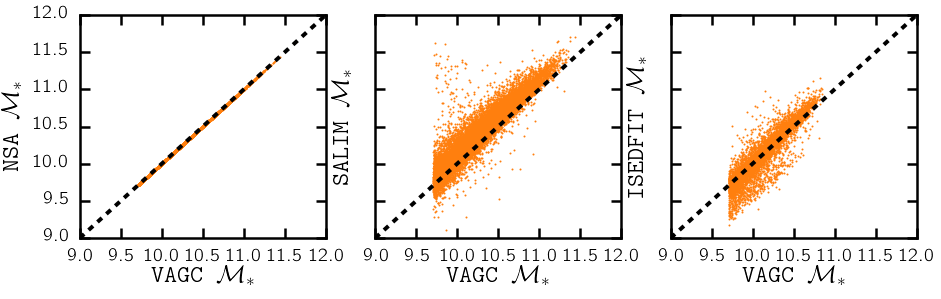

In [19]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(15,4))
for i_sub, cat in enumerate(['nsa', 'salim', 'isedfit']): 
    sub = fig.add_subplot(1,3,i_sub+1)
    
    hasmatch = np.where(vagc[cat+'_id'] != -999)
    print len(hasmatch[0]), ' matches out of ', len(vagc['ra'])
    
    sub.scatter(vagc['mass'][hasmatch], vagc[cat+'_mass'][hasmatch], c=pretty_colors[3], lw=0, s=4)
    sub.plot([9.0, 12.], [9., 12.], c='k', ls='--', lw=4)
    #sub.plot([9.0, 12.], [9.2, 12.2], c='k', ls='--', lw=4)
    
    # x-axis
    sub.set_xlim([9., 12.])
    sub.set_xlabel('VAGC $\mathcal{M}_*$', fontsize=25)
    # y-axis 
    sub.set_ylim([9., 12.])
    sub.set_ylabel(cat.upper()+' $\mathcal{M}_*$', fontsize=25)
    if i_sub != 0: 
        sub.set_yticklabels([])
plt.show()

NSA stellar masses, which is supposed to be k-correct, is sytematically lower than the VAGC k-correct stellar masses. 

Salim's GSWLC catalog has systematically higher stellar masses than the VAGC. 

iSEDfit is roughly consistent with k-correct, with mild scatter. However, only 5555 matches...

## SFR comparison

17203  matches out of  21423
18703  matches out of  21423
5555  matches out of  21423


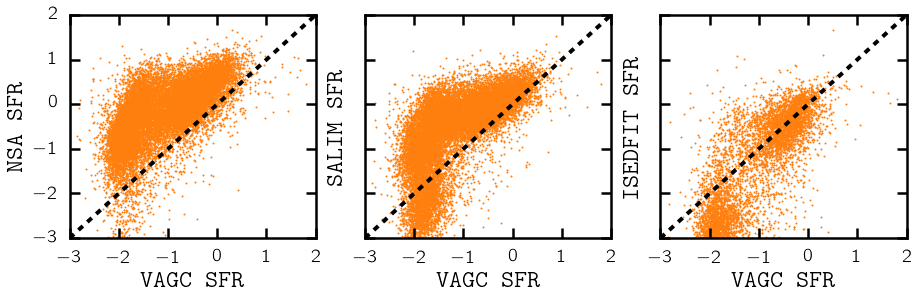

In [12]:
fig = plt.figure(figsize=(15,4))
for i_sub, cat in enumerate(['nsa', 'salim', 'isedfit']): 
    sub = fig.add_subplot(1,3,i_sub+1)
    
    hasmatch = np.where(vagc[cat+'_id'] != -999)
    print len(hasmatch[0]), ' matches out of ', len(vagc['ra'])
    
    sub.scatter(vagc['sfr'][hasmatch], vagc[cat+'_sfr'][hasmatch], c=pretty_colors[3], lw=0, s=4)
    sub.plot([-3., 3.], [-3., 3.], c='k', ls='--', lw=4)
    
    # x-axis
    sub.set_xlim([-3., 2.])
    sub.set_xlabel('VAGC SFR', fontsize=25)
    # y-axis 
    sub.set_ylim([-3., 2.])
    sub.set_ylabel(cat.upper()+' SFR', fontsize=25)
    if i_sub != 0: 
        sub.set_yticklabels([])
        
fig.savefig('sfr_comparison.png')
plt.show()

## SSFR comparison

17203  matches out of  21423
18703  matches out of  21423
5555  matches out of  21423


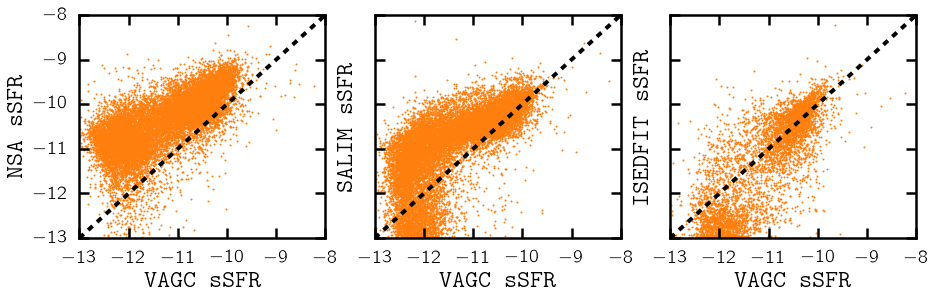

In [13]:
fig = plt.figure(figsize=(15,4))
for i_sub, cat in enumerate(['nsa', 'salim', 'isedfit']): 
    sub = fig.add_subplot(1,3,i_sub+1)
    
    hasmatch = np.where(vagc[cat+'_id'] != -999)
    print len(hasmatch[0]), ' matches out of ', len(vagc['ra'])
    
    sub.scatter(vagc['ssfr'][hasmatch], vagc[cat+'_ssfr'][hasmatch], c=pretty_colors[3], lw=0, s=4)
    sub.plot([-13., -8.], [-13., -8.], c='k', ls='--', lw=4)
    
    # x-axis
    sub.set_xlim([-13., -8.])
    sub.set_xlabel('VAGC sSFR', fontsize=25)
    # y-axis 
    sub.set_ylim([-13., -8.])
    sub.set_ylabel(cat.upper()+' sSFR', fontsize=25)
    if i_sub != 0: 
        sub.set_yticklabels([])
plt.show()

## SFR-M* comparison

17203  matches out of  21423
18703  matches out of  21423
5555  matches out of  21423


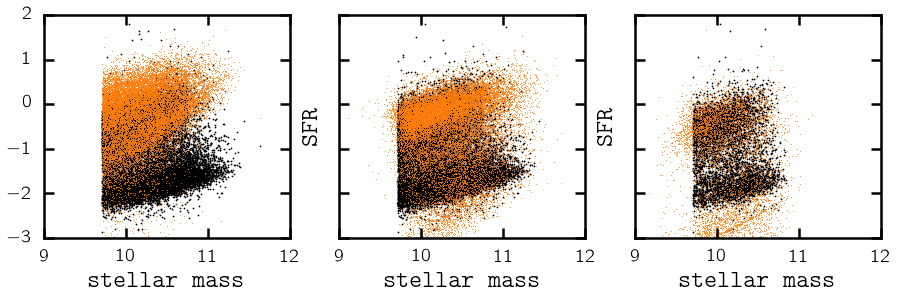

In [14]:
fig = plt.figure(figsize=(15,4))

for i_sub, cat in enumerate(['nsa', 'salim', 'isedfit']): 
    sub = fig.add_subplot(1,3,i_sub+1)
    hasmatch = np.where(vagc[cat+'_id'] != -999)
    print len(hasmatch[0]), ' matches out of ', len(vagc['ra'])
    
    sub.scatter(vagc['mass'][hasmatch], vagc['sfr'][hasmatch], c='k', lw=0, s=3)
    sub.scatter(vagc[cat+'_mass'][hasmatch], vagc[cat+'_sfr'][hasmatch], c=pretty_colors[3], lw=0, s=1)
    
    # x-axis
    sub.set_xlim([9., 12.])
    sub.set_xlabel('stellar mass', fontsize=25)
    sub.set_xticks([9., 10. ,11., 12.])
    # y-axis 
    sub.set_ylim([-3., 2.])
    if i_sub != 0: 
        sub.set_ylabel('SFR', fontsize=25)
        sub.set_yticklabels([])


## SFR/SSFR histogram comparison
SFR or SSFR histogram in bins of stellar mass

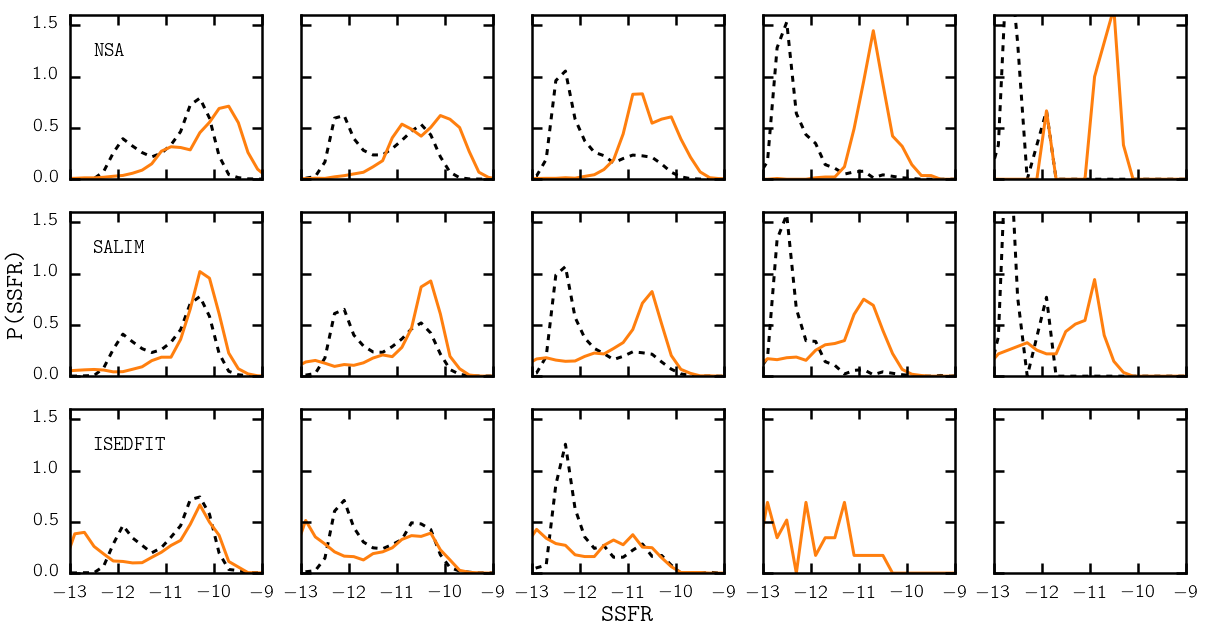

In [15]:
fig = plt.figure(figsize=(20,10))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

mass_bins = [[9.7, 10.1], [10.1, 10.5], [10.5, 10.9], [10.9, 11.3], [11.3, 11.7]]

for i_cat, cat in enumerate(['nsa', 'salim', 'isedfit']):
    for i_sub, mass_bin in enumerate(mass_bins): 
        sub = fig.add_subplot(3, len(mass_bins), i_cat*len(mass_bins)+i_sub+1)
        in_massbin = np.where((vagc['mass'] >= mass_bin[0]) & (vagc['mass'] < mass_bin[1]) & (vagc[cat+'_id'] != -999))
        
        if len(in_massbin[0]) > 0: 
            p_ssfr, ssfr_bin_edge = np.histogram(vagc['ssfr'][in_massbin], range=[-15., -7.], bins=40, normed=True)

            sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, ls='--', c='k')
        
        in_massbin2 = np.where((vagc[cat+'_mass'] >= mass_bin[0]) & (vagc[cat+'_mass'] < mass_bin[1]) & (vagc[cat+'_id'] != -999))
        if len(in_massbin2[0]) > 0: 
            p_ssfr, ssfr_bin_edge = np.histogram(vagc[cat+'_ssfr'][in_massbin2], range=[-15., -7.], bins=40, normed=True)
        
            sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3])
        
        sub.set_xlim([-13., -9.])
        sub.set_xticks([-13., -12., -11., -10., -9.])
        sub.set_ylim([0., 1.6])
        sub.set_yticks([0., 0.5, 1., 1.5])
        if i_sub != 0: 
            sub.set_yticklabels([])
        else: 
            sub.text(-12.5, 1.2, cat.upper(), fontsize=20)
        if i_cat != 2: 
            sub.set_xticklabels([])

bkgd.set_xlabel('SSFR', fontsize=25)
bkgd.set_ylabel('P(SSFR)', fontsize=25)

In [ ]:
fig = plt.figure(figsize=(20,10))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

mass_bins = [[9.7, 10.1], [10.1, 10.5], [10.5, 10.9], [10.9, 11.3], [11.3, 11.7]]

for i_cat, cat in enumerate(['nsa', 'salim', 'isedfit']):
    for i_sub, mass_bin in enumerate(mass_bins): 
        sub = fig.add_subplot(3, len(mass_bins), i_cat*len(mass_bins)+i_sub+1)
        in_massbin = np.where((vagc['mass'] >= mass_bin[0]) & (vagc['mass'] < mass_bin[1]) & (vagc[cat+'_id'] != -999))
        
        if len(in_massbin[0]) > 0: 
            p_ssfr, ssfr_bin_edge = np.histogram(vagc['sfr'][in_massbin], range=[-5.5, 3.], bins=40, normed=True)

            sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, ls='--', c='k')
        
            p_ssfr, ssfr_bin_edge = np.histogram(vagc[cat+'_sfr'][in_massbin], range=[-5.5, 3.], bins=40, normed=True)
            print vagc[cat+'_sfr'][in_massbin].min()
            sub.plot(0.5*(ssfr_bin_edge[:-1]+ssfr_bin_edge[1:]), p_ssfr, lw=3, c=pretty_colors[3])
        
        sub.set_xlim([-3., 3.])
        sub.set_xticks([-3, -1.5, 0, 1.5, 3.])
        sub.set_ylim([0., 1.6])
        sub.set_yticks([0., 0.5, 1., 1.5])
        if i_sub != 0: 
            sub.set_yticklabels([])
        else: 
            sub.text(-2.5, 1.2, cat.upper(), fontsize=20)
        if i_cat != 2: 
            sub.set_xticklabels([])

bkgd.set_xlabel('SFR', fontsize=25)
bkgd.set_ylabel('P(SFR)', fontsize=25)

## Check iSEDfit galaxies

In [ ]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['z'], vagc['mass'], c='k', s=3, lw=0)
sub.scatter(isedfit['z'], isedfit['mass'], c=pretty_colors[1], s=3, lw=0)
sub.vlines(vagc['z'].min(), 9.0, 12., lw=3, linestyle='--', color='k')
sub.vlines(vagc['z'].max(), 9.0, 12., lw=3, linestyle='--', color='k')
sub.set_xlim([0., 0.1])
sub.set_xlabel('Redshift (z)', fontsize=25)
sub.set_ylim([9., 12.])
sub.set_ylabel('Stellar Mass', fontsize=25)

# $f_Q$ comparison

In [ ]:
#NUV-r vs r-j
ised_match = np.where(vagc['isedfit_id'] != -999)

fig = plt.figure(figsize=(4,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['isedfit_r'][ised_match] - vagc['isedfit_j'][ised_match], vagc['isedfit_nuv'][ised_match] - vagc['isedfit_r'][ised_match], 
           c=pretty_colors[1], lw=0)
sub.set_xlim([-0.5, 2.])
sub.set_ylim([0., 7.])

In [ ]:
def sfq_classify_isedfit(mass, sfr, z): 
    sfq = np.repeat('starforming', len(mass))
    sfr_cut = 1.07406 * (z - 0.1) + 0.65 * (mass - 10.) - 0.492323
    
    qs = np.where(sfr < sfr_cut)
    sfq[qs] = 'quiescent'
    return sfq

In [ ]:
primus_sfq = sfq_classify_isedfit(primus['mass'], primus['sfr'], primus['z'])

In [ ]:
print primus_sfq[:10]

## COSMOS fQ from Tinker et al.(2013)

In [ ]:
cosmos_qfz088 = np.loadtxt(''.join(['/Volumes/750GB/hahn/cenque/observations/', 'qf_z0.88all.dat']), unpack=True) # 0.22 < z < 0.48
cosmos_qfz066 = np.loadtxt(''.join(['/Volumes/750GB/hahn/cenque/observations/', 'qf_z0.66all.dat']), unpack=True) # 0.48 < z < 0.74
cosmos_qfz036 = np.loadtxt(''.join(['/Volumes/750GB/hahn/cenque/observations/', 'qf_z0.36all.dat']), unpack=True) # 0.74 < z < 1.0

In [ ]:
cosmos_zbins = [[0.22, 0.48], [0.48, 0.74], [0.74,1.0]]

primus_qf_zbins = [] 
mass_bins = np.arange(9.0, 12.25, 0.25)
for i_z, zbin in enumerate(cosmos_zbins): 
    fq_bin = []
    for i_m in range(len(mass_bins)-1): 
        in_m_zbin = np.where((primus['z'] > zbin[0]) & 
                             (primus['z'] <= zbin[1]) & 
                             (primus['mass'] > mass_bins[i_m]) & 
                             (primus['mass'] <= mass_bins[i_m+1]))
        sfq_bin = primus_sfq[in_m_zbin]
        n_q = np.sum(sfq_bin == 'quiescent')
        fq_bin.append(np.float(n_q)/np.float(len(sfq_bin)))
    
    primus_qf_zbins.append([0.5 * (mass_bins[:-1] + mass_bins[1:]), fq_bin])

In [ ]:
fig = plt.figure(figsize=(6,6))
bkgd = fig.add_subplot(111, frameon=False)
bkgd.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

for i_z in range(len(cosmos_zbins)): 
    sub = fig.add_subplot(111)
    if i_z == 0: 
        sub.plot(cosmos_qfz036[0], cosmos_qfz036[1], color=pretty_colors[i_z+1], lw=3)
    elif i_z == 1: 
        sub.plot(cosmos_qfz066[0], cosmos_qfz066[1], color=pretty_colors[i_z+1], lw=3)        
    elif i_z == 2: 
        sub.plot(cosmos_qfz088[0], cosmos_qfz088[1], color=pretty_colors[i_z+1], lw=3)
        
    sub.scatter(primus_qf_zbins[i_z][0], primus_qf_zbins[i_z][1], c=pretty_colors[i_z+1], lw=0, s=25,
                label='-'.join([str(zz) for zz in cosmos_zbins[i_z]]))
    
    sub.set_xlim([9.0, 12.])
    sub.set_xticks([9., 10., 11., 12.])
    sub.set_ylim([0.005, 1.])
    #sub.set_yscale("log")
    #if i_z != 0: 
    #    sub.set_yticklabels([])
sub.legend(loc='lower right', scatterpoints=1)
bkgd.set_xlabel('stellar mass', fontsize=25)
bkgd.set_ylabel('$f_Q$', fontsize=25)